In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

In [3]:
import os
mingw_path = 'C:\\Program Files\\mingw-w64\\x86_64-8.1.0-posix-seh-rt_v6-rev0\\mingw64\\bin'
os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']
import xgboost

In [4]:
training_df = pd.read_csv("data/" + "tap_fun_train.csv")

In [5]:
X_havespent = training_df.iloc[:,2:108]
y_havespent = training_df.prediction_pay_price-training_df.pay_price>0

In [6]:
X_havespent_train, X_havespent_test, y_havespent_train, y_havespent_test = train_test_split(X_havespent, y_havespent, test_size=0.3, stratify=y_havespent)

In [58]:
dtrain = xgboost.DMatrix(data=X_havespent_train, label=y_havespent_train)

In [41]:
param = {'max_depth':5, 'eta':1, 'silent':1, 'objective':'binary:logistic' }
num_round = 100

In [59]:
bst = xgboost.train(param, dtrain, num_round)

In [61]:
dtest = xgboost.DMatrix(data=X_havespent_test)

In [62]:
roc_auc_score(y_havespent_test, bst.predict(dtest))

0.9666185745759999

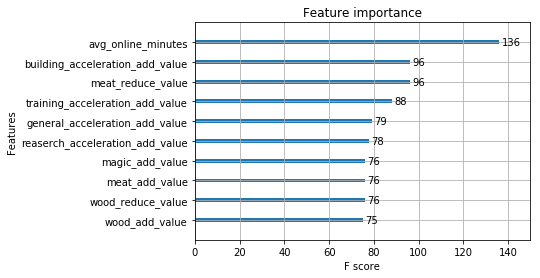

In [70]:
xgboost.plot_importance(bst, max_num_features=10)

In [7]:
training_spender_df = training_df[training_df.prediction_pay_price-training_df.pay_price>0]
X_spender = training_spender_df.iloc[:,2:108]
y_spender = training_spender_df.prediction_pay_price-training_spender_df.pay_price

In [8]:
X_spender_train, X_spender_test, y_spender_train, y_spender_test = train_test_split(X_spender, y_spender, test_size=0.3)

In [9]:
dtrain = xgboost.DMatrix(data=X_spender_train, label=y_spender_train)
dtest = xgboost.DMatrix(data=X_spender_test)

In [79]:
param = {'max_depth':5, 'eta':1, 'silent':1, 'objective':'reg:linear', 'booster':'gbtree'}
num_round = 100

In [80]:
bst_spender_rev = xgboost.train(param, dtrain, num_round)

In [81]:
pred_spender_test = bst_spender_rev.predict(dtest)

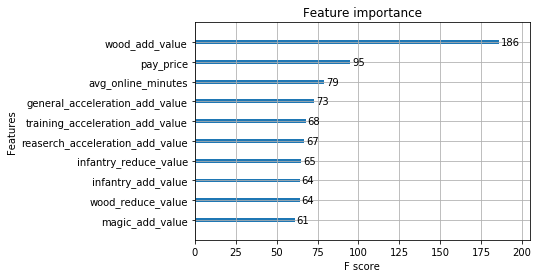

In [83]:
xgboost.plot_importance(bst_spender_rev, max_num_features=10)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


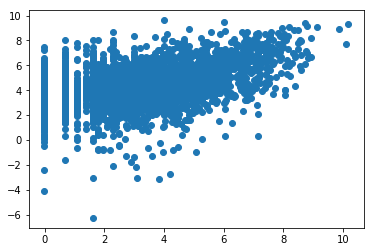

In [89]:
plt.scatter(x=np.log(y_spender_test), y=np.log(pred_spender_test))

In [10]:
from skopt import BayesSearchCV
from xgboost import XGBRegressor

In [24]:
bayes_cv_tuner = BayesSearchCV(
    estimator = XGBRegressor(
        n_jobs = 1,
        objective = 'reg:linear',
        booster = 'gbtree',
        silent=True
    ),
    search_spaces = {
        'learning_rate': (0.01, 1.0, 'log-uniform'),
        'min_child_weight': (0, 10),
        'max_depth': (2, 50),
        'max_delta_step': (0, 20),
        'subsample': (0.01, 1.0, 'uniform'),
        'colsample_bytree': (0.1, 1.0, 'uniform'),
        'colsample_bylevel': (0.01, 1.0, 'uniform'),
        'reg_lambda': (1e-9, 1000, 'log-uniform'),
        'reg_alpha': (1e-9, 1.0, 'log-uniform'),
        'gamma': (1e-9, 0.5, 'log-uniform'),
        'min_child_weight': (0, 5),
        'n_estimators': (50, 100),
        'scale_pos_weight': (1e-6, 500, 'log-uniform')
    },    
    scoring = 'neg_mean_squared_error',
    cv = 3,
    n_jobs = 6,
    n_points = 2,
    n_iter = 50,   
    verbose = 0,
    refit = True
)

In [13]:
def status_print(optim_result):
    """Status callback durring bayesian hyperparameter search"""
    
    # Get all the models tested so far in DataFrame format
    all_models = pd.DataFrame(bayes_cv_tuner.cv_results_)    
    
    # Get current parameters and the best parameters    
    best_params = pd.Series(bayes_cv_tuner.best_params_)
    print('Model #{}\nBest neg_mean_squared_error: {}\nBest params: {}\n'.format(
        len(all_models),
        np.round(bayes_cv_tuner.best_score_, 4),
        bayes_cv_tuner.best_params_
    ))
    
    # Save all model results
    clf_name = bayes_cv_tuner.estimator.__class__.__name__
    all_models.to_csv(clf_name+"_cv_results.csv")

In [25]:
result = bayes_cv_tuner.fit(X_spender_train, y_spender_train, callback=status_print)

Model #2
Best ROC-AUC: -793930.6739
Best params: {'colsample_bylevel': 0.8963838568305035, 'colsample_bytree': 0.6156027271079825, 'gamma': 0.46965785454678666, 'learning_rate': 0.022153482854171964, 'max_delta_step': 1, 'max_depth': 6, 'min_child_weight': 4, 'n_estimators': 80, 'reg_alpha': 2.8699124785863754e-07, 'reg_lambda': 1.09150237287782e-05, 'scale_pos_weight': 2.8885340162347663e-06, 'subsample': 0.0501889536847651}

Model #4
Best ROC-AUC: -793901.2826
Best params: {'colsample_bylevel': 0.133340267197307, 'colsample_bytree': 0.19023102762233465, 'gamma': 0.012282088661733186, 'learning_rate': 0.9836276063290766, 'max_delta_step': 2, 'max_depth': 28, 'min_child_weight': 2, 'n_estimators': 73, 'reg_alpha': 1.6693781201649717e-07, 'reg_lambda': 6.637065200622467e-06, 'scale_pos_weight': 1.8159423504237314e-06, 'subsample': 0.24068770045787272}

Model #6
Best ROC-AUC: -656366.1494
Best params: {'colsample_bylevel': 0.9304535110817908, 'colsample_bytree': 0.49994639321390055, 'gam

Model #42
Best ROC-AUC: -562460.5428
Best params: {'colsample_bylevel': 0.4800098253729306, 'colsample_bytree': 0.3541008295545027, 'gamma': 1.7460215732487085e-09, 'learning_rate': 0.09148099223043875, 'max_delta_step': 10, 'max_depth': 22, 'min_child_weight': 3, 'n_estimators': 70, 'reg_alpha': 5.797439201127775e-09, 'reg_lambda': 0.01543390736403729, 'scale_pos_weight': 216.9891255344863, 'subsample': 0.5695077427139841}

Model #44
Best ROC-AUC: -562460.5428
Best params: {'colsample_bylevel': 0.4800098253729306, 'colsample_bytree': 0.3541008295545027, 'gamma': 1.7460215732487085e-09, 'learning_rate': 0.09148099223043875, 'max_delta_step': 10, 'max_depth': 22, 'min_child_weight': 3, 'n_estimators': 70, 'reg_alpha': 5.797439201127775e-09, 'reg_lambda': 0.01543390736403729, 'scale_pos_weight': 216.9891255344863, 'subsample': 0.5695077427139841}

Model #46
Best ROC-AUC: -562460.5428
Best params: {'colsample_bylevel': 0.4800098253729306, 'colsample_bytree': 0.3541008295545027, 'gamma': 1

In [27]:
bst_spender_rev_tuned = bayes_cv_tuner.predict(X_spender_test)

费好大劲儿，预测精度感人

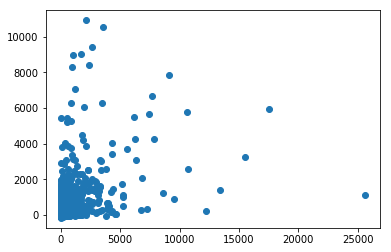

In [32]:
plt.scatter(x=y_spender_test, y=bst_spender_rev_tuned)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


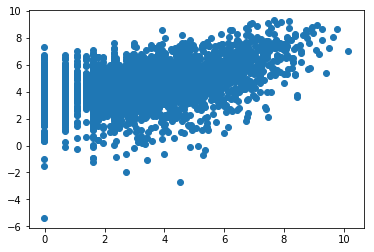

In [33]:
plt.scatter(x=np.log(y_spender_test), y=np.log(bst_spender_rev_tuned))